# General State Markov Chains and MCMC
**Author:** Ivan Vovk

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as Q
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

## **1. Metropolis-Hastings Langevin Algorithm**

If we have:

 
 $$U(x) = \frac{x_0^2}{2p} + (x_1 + bx_0^2 - pb)^2 + \sum_{k=2}^{n}{\frac{x_k^2}{2}} =$$

 
 $$= \frac{x_0^2}{2p} + x_1^2 + 2bx_1x_0^2 - 2bpx_1 - 2b^2px_0^2 + b^2x_0^4 + b^2p^2 + \sum_{k=2}^{n}{\frac{x_k^2}{2}}$$

 then the gradient of $U(x)$:

 
 $$\nabla U(x) = (\frac{x_0}{p} + 4bx_0x_1 - 4b^2px_0 + 4b^2x_0^3;$$

 
 $$2x_1 + 2bx_0^2 - 2bp;$$

 
 $$x_2;$$

 
 $$x_3;$$

 
 $$...)$$

 
 Expectation for the second dimension:

 
 $$E(X_1) = \int_{R^d} x_1 \exp{(-U(x))} dx_0 dx_1 ... dx_d =$$

 
 $$= const_{1} \iint_{R^2} x_1 \exp{(-(x_1 - (pb - bx_0^2))^2}  \exp{(-\frac{x_0^2}{2p})} dx_0 dx_1$$

 
 But $x_1 \exp{(-(x_1 - (pb - bx_0^2))^2}$ is just a normal dist. with mean $pb - bx_0^2$ and variance $\frac{1}{2}$:

 
 $$= const_{2} \int_R \exp(-\frac{x_0^2}{2p}) (pb - bx_0^2) dx_0 = \sqrt{2p} pb \int_R \exp{\left[-\left(\frac{x_0}{\sqrt{2p}}\right)^2\right]} d\frac{x_0}{\sqrt{2p}} - b \int x_0^2 \exp(-\frac{x_0^2}{2p}) dx_0$$

 
 But $\int_R \exp{\left[-\left(\frac{x_0}{\sqrt{2p}}\right)^2\right]} d\frac{x_0}{\sqrt{2p}} = \pi$ and $b \int x_0^2 \exp(-\frac{x_0^2}{2p}) dx_0 = \sqrt{2p \pi}$, then it is equal to:

 
 $$const_{2} \cdot (\sqrt{2p \pi} bp - \sqrt{2p \pi} bp) = 0$$

In [662]:
def U(x, p=100, b=0.1):
    return x[0]**2 / (2 * p) + (x[1] + b * x[0] ** 2 - p * b)**2 + (x[2:]**2).sum() / 2

def grad_U(x, p=100, b=0.1):
    grad = np.zeros(x.shape)
    for i in range(x.shape[0]):
        if i == 0:
            grad[0] = x[0] / p + 4 * b * x[0] * x[1] - 4 * (b**2) * p * x[0] + 4 * (b**2) * (x[0] ** 3)
        elif i == 1:
            grad[1] = 2 * x[1] + 2 * b * (x[0]**2) - 2 * b * p
        else:
            grad[i] = x[i]
    return grad
    
def pi(x, p=100, b=0.1):
    return np.exp(-U(x, p, b))

def kernel(curr_state, h=0.5, d=10, p=100, b=0.1):
    mu = curr_state - h * grad_U(curr_state, p, b)
    sigma = 2 * h * np.ones(d)
    return np.random.normal(loc=mu, scale=sigma, size=d)

def acceptance_prob(curr_state, candidate, p=100, b=0.1, h=0.1):
    return min(
        1,
        pi(candidate, p, b) / (pi(curr_state, p, b) + 1e-15) \
        * Q(candidate - h * grad_U(candidate, p, b), 2 * h * np.eye(10)).pdf(candidate)) \
        / (Q(curr_state - h * grad_U(curr_state, p, b), 2 * h * np.eye(10)).pdf(curr_state) + 1e-15)

def gen_samples_mala(N=10000, d=10, h=1e-3, p=100, b=0.1, random_state=123):
    # Initial point
    np.random.seed(random_state)
    curr_state = np.random.normal(
        loc=[np.random.choice([-20, 20]), -12] + [0] * (d - 2),
        scale=0.5
    )
    curr_state = kernel(curr_state, h, d, p, b)
    
    accepted_samples = []
    rejected_samples = []
    while len(accepted_samples) + len(rejected_samples) != N:  # for h search
        # Sample candidate from our kernel
        candidate = kernel(curr_state, h, d, p, b)

        # Calculate acceptance probability
        u = np.random.uniform(0, 1)
        if u <= acceptance_prob(curr_state, candidate, p, b, h=h):
            curr_state = candidate
            accepted_samples.append(candidate)
        else:
            rejected_samples.append(candidate)
    return accepted_samples, rejected_samples

### How $U$ and $\pi$ look like in 2D case

In [663]:
U_points = []
pi_points = []

U_heatmap = np.zeros((200, 200))
pi_heatmap = np.zeros((200, 200))
for i, x1 in enumerate(np.linspace(-40, 40, 200)):
    for j, x2 in enumerate(np.linspace(-50, 30, 200)):
        U_heatmap[i, j] = U(np.array([x1, x2]))
        pi_heatmap[i, j] = pi(np.array([x1, x2]))

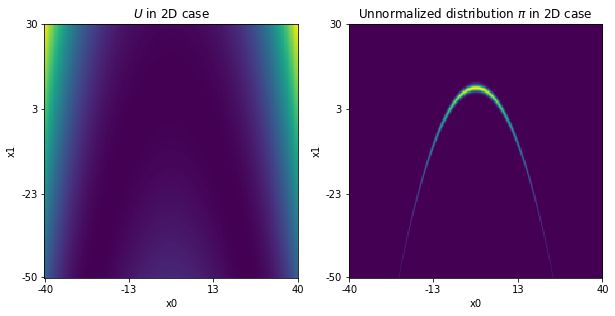

In [664]:
plt.figure(figsize=(10, 5));
plt.subplot(1, 2, 1);
plt.imshow(U_heatmap.T, origin='bottom');
plt.xticks(np.linspace(0, 200, 4, dtype=int), np.linspace(-40, 40, 4, dtype=int));
plt.yticks(np.linspace(0, 200, 4, dtype=int), np.linspace(-50, 30, 4, dtype=int));
plt.title('$U$ in 2D case');
plt.xlabel('x0');
plt.ylabel('x1');

plt.subplot(1, 2, 2);
plt.imshow(pi_heatmap.T, origin='bottom');
plt.xticks(np.linspace(0, 200, 4, dtype=int), np.linspace(-40, 40, 4, dtype=int));
plt.yticks(np.linspace(0, 200, 4, dtype=int), np.linspace(-50, 30, 4, dtype=int));
plt.title('Unnormalized distribution $\pi$ in 2D case');
plt.xlabel('x0');
plt.ylabel('x1');

### Optimal `h` parameter search

In [665]:
ratios = []
h_grid = np.linspace(1e-7, 0.2, 100)

for i, h in enumerate(tqdm(h_grid)):
    accepted, rejected = gen_samples_mala(N=50, h=h, random_state=i)
    ratios.append(len(accepted) / (len(accepted) + len(rejected)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.77it/s]


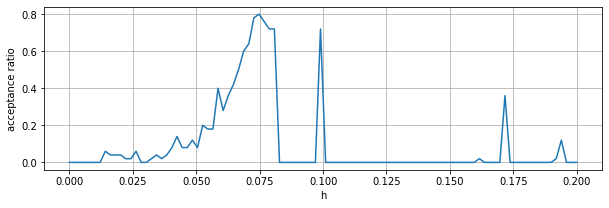

In [666]:
plt.figure(figsize=(10, 3));
plt.grid(True);
plt.plot(h_grid, ratios);
plt.xlabel('h');
plt.ylabel('acceptance ratio');

### Sampling

In [667]:
accepted, rejected = gen_samples_mala(N=10000, h=0.075, random_state=1234)

In [668]:
len(accepted), len(rejected)

(7479, 2521)

### Visualization

In [669]:
pca = PCA(n_components=2)
reducted_accepted = pca.fit_transform(accepted)

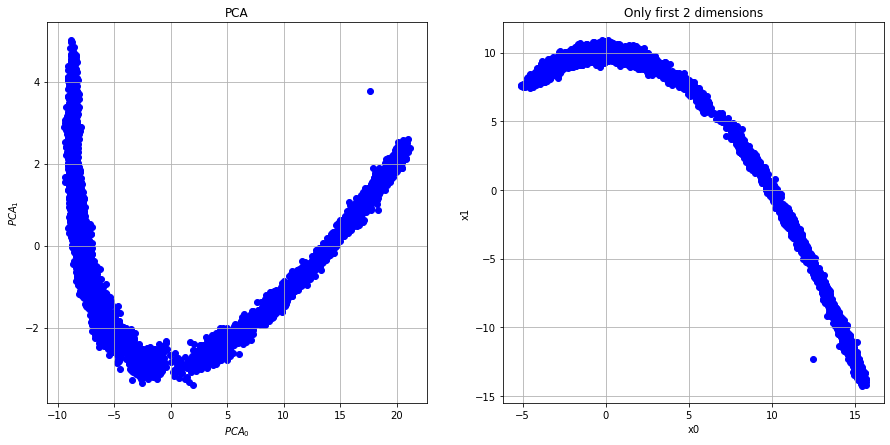

In [670]:
plt.figure(figsize=(15,7));

plt.subplot(1, 2, 1);
plt.title('PCA')
plt.grid(True);
plt.scatter(x=[point[0] for point in reducted_accepted],
            y=[point[1] for point in reducted_accepted], color='blue');
plt.xlabel('$PCA_0$');
plt.ylabel('$PCA_1$');

plt.subplot(1, 2, 2);
plt.title('Only first 2 dimensions')
plt.grid(True);
plt.scatter(x=[point[0] for point in accepted],
            y=[point[1] for point in accepted], color='blue');
plt.xlabel('x0');
plt.ylabel('x1');

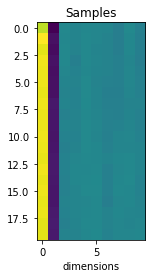

In [671]:
plt.imshow(np.array(accepted[:20]));
plt.title('Samples');
plt.xlabel('dimensions');

### Empirical expectation for the second dimension

In [672]:
samples = []
for i in tqdm(range(10)):
    samples.append(gen_samples_mala(N=10000, h=0.075, random_state=i)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.28s/it]


In [673]:
x2_samples = [[item[1] for item in sample] for sample in samples]
print('Averaged expectation = {}'.format(sum(map(sum, x2_samples)) / sum(map(len, x2_samples))))

Averaged expectation = 0.9483374489058306


In [674]:
for i, sample in enumerate(x2_samples):
    print('Expectation for {} test set ='.format(i + 1), np.mean(sample))

Expectation for 1 test set = 0.5469479411089123
Expectation for 2 test set = -5.981519352921162
Expectation for 3 test set = 5.003603744608691
Expectation for 4 test set = -0.5052876349197161
Expectation for 5 test set = 4.851776732133447
Expectation for 6 test set = -0.6106030284328812
Expectation for 7 test set = 3.3526113923337286
Expectation for 8 test set = 5.350478001848063
Expectation for 9 test set = 5.118676499033835
Expectation for 10 test set = -8.081937847749781


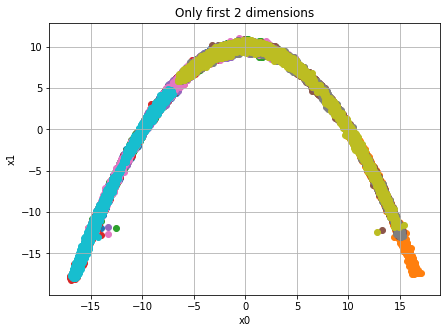

In [675]:
plt.figure(figsize=(7, 5));
plt.title('Only first 2 dimensions');
plt.grid(True);
for sample in samples:
    plt.scatter(x=[point[0] for point in sample],
                y=[point[1] for point in sample]);
plt.xlabel('x0');
plt.ylabel('x1');

___
## **2. Random Walk Metropolis Algorithm**

In [770]:
def acceptance_prob_rwm(curr_state, candidate, p=100, b=0.1):
    return min(1, pi(candidate, p, b) / (1e-20 + pi(curr_state, p, b)))

def kernel_rwm(curr_state, d=10, proposal='normal', proposal_params={'loc': 0., 'scale': 0.1}):
    proposal_params.update({'size': d})
    proposal_dist = getattr(np.random, proposal)
    proposal_jump = proposal_dist(**proposal_params)
    candidate = curr_state + proposal_jump
    return candidate

def gen_samples_rwm(
    N=10000,
    d=10, p=100, b=0.1,
    proposal='normal',
    proposal_params={'loc': 0., 'scale': 0.2},
    random_state=123
):
    # Initial point
    np.random.seed(seed=random_state)
    curr_state = np.random.normal(
        loc=[np.random.choice([-10, 10]), -5] + [0] * (d - 2),
        scale=0.5
    )
    curr_state = kernel(curr_state, h, d, p, b)
    
    accepted_samples = []
    rejected_samples = []
    while len(accepted_samples) + len(rejected_samples) != N:  # for h search
        # Sample candidate from our kernel
        candidate = kernel_rwm(curr_state, d, proposal=proposal, proposal_params=proposal_params)

        # Calculate acceptance probability
        u = np.random.uniform(0, 1)
        if u <= acceptance_prob_rwm(curr_state, candidate, p, b):
            curr_state = candidate
            accepted_samples.append(candidate)
        else:
            rejected_samples.append(candidate)
    return accepted_samples, rejected_samples

### Normal proposal

In [771]:
scale_grid = np.linspace(1e-7, 2, 100)

In [772]:
acceptance_ratios = []
for i, scale in enumerate(tqdm(scale_grid)):
    accepted_rwm, rejected_rwm = gen_samples_rwm(N=200, proposal_params={'loc': 0., 'scale': scale}, random_state=i)
    acceptance_ratios.append(len(accepted_rwm) / (len(accepted_rwm) + len(rejected_rwm)))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 154.57it/s]


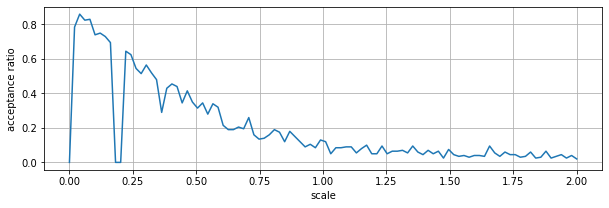

In [773]:
plt.figure(figsize=(10, 3));
plt.grid(True);
plt.plot(scale_grid, acceptance_ratios);
plt.xlabel('scale');
plt.ylabel('acceptance ratio');

In [780]:
accepted_rwm, rejected_rwm = gen_samples_rwm(N=10000, proposal_params={'loc': 0., 'scale': 0.2}, random_state=1234)
len(accepted_rwm), len(rejected_rwm)

(7176, 2824)

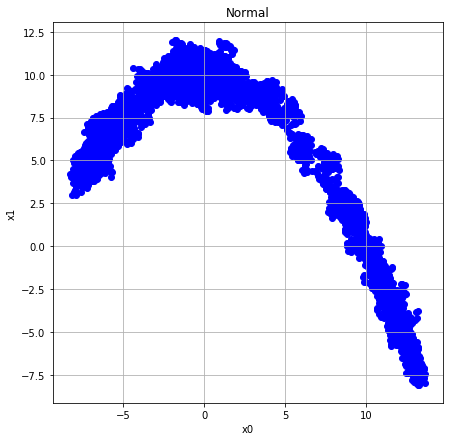

In [781]:
plt.figure(figsize=(7,7));

plt.title('Normal')
plt.grid(True);
plt.scatter(x=[point[0] for point in accepted_rwm],
            y=[point[1] for point in accepted_rwm], color='blue');
plt.xlabel('x0');
plt.ylabel('x1');

#### Empirical expectation for the second dimension

In [786]:
samples = []
for i in tqdm(range(10)):
    samples.append(gen_samples_rwm(N=10000, proposal_params={'loc': 0., 'scale': 0.2}, random_state=i)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]


In [787]:
x2_samples = [[item[1] for item in sample] for sample in samples]
print('Empirical expectation = {}'.format(sum(map(sum, x2_samples)) / sum(map(len, x2_samples))))

Empirical expectation = -0.4613797148583912


In [788]:
for i, sample in enumerate(x2_samples):
    print('Expectation for {} test set ='.format(i + 1), np.mean(sample))

Expectation for 1 test set = 1.0980074339429238
Expectation for 2 test set = -26.360255270652004
Expectation for 3 test set = 6.757234524603925
Expectation for 4 test set = -3.0422950626499166
Expectation for 5 test set = 6.863646845122966
Expectation for 6 test set = -0.4562547420100132
Expectation for 7 test set = 3.3177662080023183
Expectation for 8 test set = 6.346363192189917
Expectation for 9 test set = 5.712058625095891
Expectation for 10 test set = -10.60647168589304


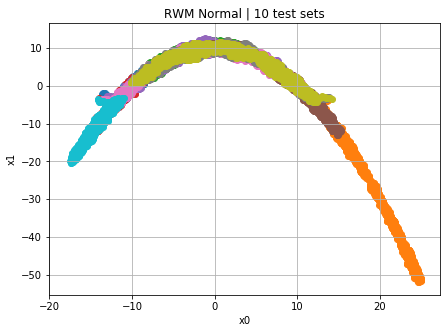

In [789]:
plt.figure(figsize=(7, 5));
plt.title('RWM Normal | 10 test sets');
plt.grid(True);
for sample in samples:
    plt.scatter(x=[point[0] for point in sample],
                y=[point[1] for point in sample]);
plt.xlabel('x0');
plt.ylabel('x1');

### Laplace proposal

In [790]:
scale_grid = np.linspace(1e-7, 2, 100)

In [791]:
acceptance_ratios = []
for i, scale in enumerate(tqdm(scale_grid)):
    accepted, rejected = gen_samples_rwm(
        N=200, proposal='laplace', proposal_params={'loc': 0., 'scale': scale}, random_state=i)
    acceptance_ratios.append(len(accepted) / (len(accepted) + len(rejected)))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.42it/s]


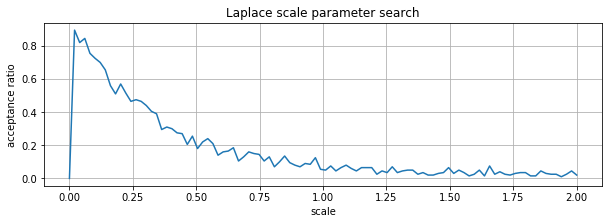

In [792]:
plt.figure(figsize=(10, 3));
plt.grid(True);
plt.plot(scale_grid, acceptance_ratios);
plt.xlabel('scale');
plt.ylabel('acceptance ratio');
plt.title('Laplace scale parameter search');

In [793]:
accepted_rwm_laplace, rejected_rwm_laplace = gen_samples_rwm(
    N=10000, proposal='laplace', proposal_params={'scale': 0.2}, random_state=1234
)
len(accepted_rwm_laplace), len(rejected_rwm_laplace)

(6294, 3706)

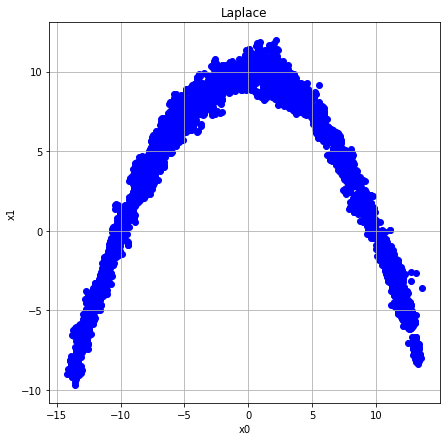

In [794]:
plt.figure(figsize=(7,7));

plt.title('Laplace')
plt.grid(True);
plt.scatter(x=[point[0] for point in accepted_rwm_laplace],
            y=[point[1] for point in accepted_rwm_laplace], color='blue');
plt.xlabel('x0');
plt.ylabel('x1');

#### Empirical expectation for the second dimension

In [826]:
samples = []
for i in tqdm(range(10)):
    samples.append(gen_samples_rwm(
        N=10000, proposal='laplace', proposal_params={'scale': 0.21}, random_state=i)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.70it/s]


In [827]:
x2_samples = [[item[1] for item in sample] for sample in samples]
print('Empirical expectation = {}'.format(sum(map(sum, x2_samples)) / sum(map(len, x2_samples))))

Empirical expectation = -0.2533127617192736


In [828]:
for i, sample in enumerate(x2_samples):
    print('Expectation for {} test set ='.format(i + 1), np.mean(sample))

Expectation for 1 test set = -5.59555352715351
Expectation for 2 test set = -1.936112123546119
Expectation for 3 test set = 3.4245638267381624
Expectation for 4 test set = 3.9091652897183145
Expectation for 5 test set = -14.151362793372034
Expectation for 6 test set = 1.7589464607132925
Expectation for 7 test set = -1.1776340659773237
Expectation for 8 test set = -2.3491315042559617
Expectation for 9 test set = 5.150772424812467
Expectation for 10 test set = 5.681332794378427


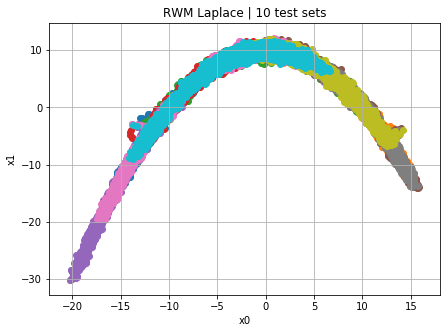

In [829]:
plt.figure(figsize=(7, 5));
plt.title('RWM Laplace | 10 test sets');
plt.grid(True);
for sample in samples:
    plt.scatter(x=[point[0] for point in sample],
                y=[point[1] for point in sample]);
plt.xlabel('x0');
plt.ylabel('x1');